# Quick Analysis 

Notebook to perform quick analysis and visualization to debug the simulation.

In [144]:
%matplotlib inline

import os
import sys 
import json
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from operator import itemgetter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.config import settings

In [145]:
with open('../test.json', 'r') as f:
    results = json.load(f)

In [146]:
def configure(**kwargs):
    """
    Sets various configurations for Seaborn from the settings or arguments.
    """

    # Get configurations to do modifications on them.
    style   = kwargs.pop('style', settings.vizualization.style)
    context = kwargs.pop('context', settings.vizualization.context)
    palette = kwargs.pop('palette', settings.vizualization.palette)

    # Set the configurations on SNS
    sns.set_style(style)
    sns.set_context(context)
    sns.set_palette(palette)

    return kwargs

In [147]:
def plot_workload(results, devices=False, **kwargs):
    """
    Helper function to make a timeline plot of reads/writes.
    If devices is True, plots timeline by device, else location.
    """
    kwargs  = configure(**kwargs)
    outpath = kwargs.pop('savefig', None)
    series  = 0 if devices else 1

    read_color  = kwargs.pop('read_color', '#E20404')
    write_color = kwargs.pop('write_color', '#1E05D9')
    locations   = defaultdict(list)

    # Build the data from the read and write time series
    for key in ('tag read', 'tag write'):
        for item in results['results'][key]:
            locations[item[series]].append(
                item + [key]
            )

    # Sort the data by timestamp
    for key in locations:
        locations[key].sort(key=itemgetter(0))

    # Create the visualization
    rx = []
    ry = []
    wx = []
    wy = []

    for idx, (key, lst) in enumerate(sorted(locations.items(), key=itemgetter(0), reverse=True)):
        for item in lst:
            if item[2] > 200000: continue
            if item[-1] in {'tag read', 'read'}:
                rx.append(int(item[2]))
                ry.append(idx) 
            else:
                wx.append(int(item[2]))
                wy.append(idx)

    plt.figure(figsize=(22,8))
    plt.ylim((-1,len(locations)))
    plt.xlim((-1000, max(max(rx), max(wx))+1000))
    plt.xlabel("timestep in milliseconds")
    plt.yticks(range(len(locations)), sorted(locations.keys(), reverse=True))
    plt.ylabel("Devices" if devices else "Object Names")
    plt.scatter(rx, ry, color=read_color, label="reads", alpha=0.75, s=45)
    plt.scatter(wx, wy, color=write_color, label="writes", alpha=0.75, s=45)
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Accesses for 10 objects in a 10 node cluster with 4 users.")

    if outpath:
        return plt.savefig(outpath, format='png', dpi=300)

    return plt

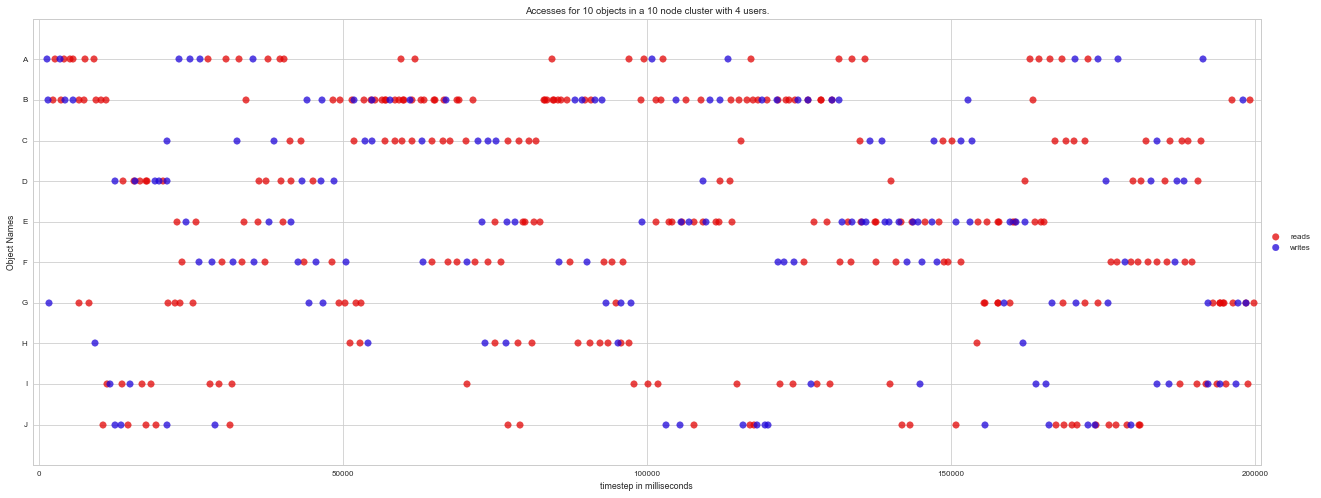

In [148]:
plot_workload(results, devices=False, savefig='/Users/benjamin/Desktop/users4.png')